In [ ]:
#install python packages to run this notebook 
!pip install rasterio geopandas  osmnx unidecode

     |████████████████████████████████| 19.1MB 1.4MB/s 
     |████████████████████████████████| 1.0MB 29.4MB/s 
     |████████████████████████████████| 102kB 9.1MB/s 
     |████████████████████████████████| 245kB 42.5MB/s 
     |████████████████████████████████| 15.3MB 281kB/s 
     |████████████████████████████████| 6.6MB 31.4MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 1.0MB 29.1MB/s 
     |████████████████████████████████| 10.3MB 28.3MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Found existing installati

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import osmnx as ox
import pandas as pd

import rasterio
from rasterio import features
from rasterio.plot import show

import os
from os import path as op
from shapely.wkt import loads

import unidecode

%matplotlib inline

In [ ]:
# Mount drive to google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set a Google Drive directory as the default working directory
root_dir = "/content/drive/MyDrive/sat_images/places/"

# Make sure that folder exists
if (not op.isdir(root_dir)):
  os.mkdir(root_dir)

Mounted at /content/drive


In [ ]:
# If not on Colab you'll need install the earth-engine Python API
#!pip install earthengine-api #earth-engine Python API

# Earth Engine Python API
import ee 
# Athenticate to your GEE account. 
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=xubkdvH3Clap5Hf-XYUa5wl70YBsPqmR6z-MabpRlo8&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g7OSBJ-YWvOM94ZU5ZqSanaR6coj2ex4hjeUEfp0Vr4PTGjCgrA0u8

Successfully saved authorization token.


/usr/local/lib/python3.7/dist-packages/ee/data.py:219: ResourceWarning: unclosed file <_io.TextIOWrapper name='/root/.config/earthengine/credentials' mode='r' encoding='UTF-8'>
  tokens = json.load(open(oauth.get_credentials_path()))
/usr/local/lib/python3.7/dist-packages/httplib2shim/__init__.py:45: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(proxy_info, collections.Callable):


Got the following place: Brisbane City, Queensland, Australia
Brisbane_City_Queensland_Australia
please wait while I get the green areas tagged in Brisbane City, Queensland, Australia
It can take some time... 
0    259479244
Name: place_id, dtype: int64
                      name                                           geometry
(way, 9906157)        wood  POLYGON ((153.02133 -27.38832, 153.02057 -27.3...
(way, 10591962)       wood  POLYGON ((153.00718 -27.44395, 153.00684 -27.4...
(way, 17993140)       wood  POLYGON ((153.02277 -27.43032, 153.02323 -27.4...
(way, 18009785)       wood  POLYGON ((153.05300 -27.52505, 153.05262 -27.5...
(way, 18562493)       wood  POLYGON ((152.99834 -27.40757, 152.99969 -27.4...
...                    ...                                                ...
(relation, 6376009)   park  POLYGON ((153.11015 -27.46426, 153.11015 -27.4...
(relation, 11140701)  park  POLYGON ((153.17831 -27.45905, 153.17855 -27.4...
(relation, 11201842)  park  POLYGON ((153.14

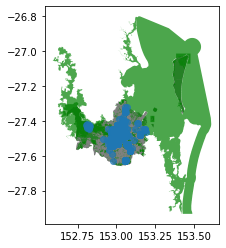

In [ ]:
# Any place worlwide you want (city/place name, country)
place_name = input('Any worlwide place to search (as "Paris, France"): ')

# search the place area, based on the given name  
place_area = ox.geocoder.geocode_to_gdf(place_name)
print('Got the following place: ' + place_area.display_name[0])
area_name = place_area.display_name[0].replace(' ','_').replace(',','').replace("'","")
area_name = unidecode.unidecode(area_name)[:80]
print(area_name)

# To measure an area of the map, we need to ensure we are using an equal area projection. 
# For now using one of the recommended on this post: Mollweide Projection (EPSG:54009), but needs further investigation
# https://gis-ops.com/measuring-distances-and-why-projections-matter-practical-examples/  
crs_type = 'EPSG:4326'

#set minimum number of class samples in order be considerer for classification 
min_count_learning = 50

place_area.to_crs(crs=crs_type, inplace=True)

# selected the OSM tags that I consider as green, but can be reviewed)
tags_green_natural =  {'natural': ['tree', 'wood', 'scrub', 'wetland', 'grassland', 'tree_row', 'heath', 'fell', 'shrub', 'grass', 'forest', 'bush']}
    #see:  https://wiki.openstreetmap.org/wiki/Key:natural
tags_green_landuse =  {'landuse': ['farmland', 'forest', 'grass', 'meadow', 'orchard', 'farmyard', 'vineyard', 'allotments', 'recreation_ground', 'village_green', 'plant_nursery', 'farm', 'flowerbed', 'plantation', 'agriculture', 'garden']}
    #see:  https://wiki.openstreetmap.org/wiki/Key:landuse
tags_green_leisure = {'leisure': ['garden', 'golf_course', 'nature_reserve', 'park']}
    #see:  https://wiki.openstreetmap.org/wiki/Key:leisure

green_tags = {**tags_green_natural, **tags_green_landuse, **tags_green_leisure}

print('please wait while I get the green areas tagged in ' + place_area.display_name[0])
print('It can take some time... ')
# get dataframe of green areas from the defined place 
green_areas = ox.geometries_from_place(place_name, green_tags).to_crs(crs=crs_type)

# Plot the green areas (needs improvement, i don't know why we get blue areas) 
fig, ax = plt.subplots()
print(place_area.place_id)
place_area.plot(ax=ax, facecolor='gray')
green_areas.plot(ax=ax, facecolor='green', alpha=0.7)


# greens_df will colect all the green areas/points of the place 
greens_df = gpd.GeoDataFrame(columns=['name','geometry'])
for area_type  in green_tags:
  for area in green_tags[area_type]:
    if area_type in green_areas.columns:
      sub_df = green_areas[green_areas[area_type]==area][['geometry']]
      sub_df['name'] = green_areas[green_areas[area_type]==area][area_type]
      greens_df = greens_df.append(sub_df)

greens_df = greens_df.loc[greens_df.geometry.geom_type.isin(['Polygon','MultiPolygon'])]

#new_df = greens_df.groupby(['name']).count()
#new_index = new_df[new_df.geometry.gt(min_count_learning)].index.values
#greens_df = greens_df.loc[greens_df['name'].isin(new_index)]
# Set a Google Drive directory as the default working directory
root_dir = "/content/drive/MyDrive/sat_images/places/" + area_name +"/"

# Make sure that folder exists
if (not op.isdir(root_dir)):
  os.mkdir(root_dir)

greens_df.to_csv(root_dir + 'green_areas.csv')
print(greens_df)

In [ ]:
start_date ='2020-01-01'
end_date = '2020-12-31'
cloud_pct = 2
band_sel = ('B2', 'B3', 'B4', 'B8')
ee.Projection.crs('EPSG:4326')

bounds = greens_df.total_bounds.tolist()
print(bounds)

aoi = ee.Geometry.Rectangle(bounds)

sentinel_scenes = ee.ImageCollection("COPERNICUS/S2")\
    .filterBounds(aoi)\
    .filterDate(start_date, end_date)\
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',cloud_pct))\
    .select(band_sel)

scenes = sentinel_scenes.getInfo()
[print(scene['id']) for scene in scenes["features"]]

sentinel_mosaic = sentinel_scenes.mean().rename(band_sel)

[152.5912782, -27.9332613, 153.6116035, -26.8022363]
COPERNICUS/S2/20200105T000239_20200105T000235_T56JMQ
COPERNICUS/S2/20200105T000239_20200105T000235_T56JMR
COPERNICUS/S2/20200105T000239_20200105T000235_T56JNQ
COPERNICUS/S2/20200105T000239_20200105T000235_T56JNR
COPERNICUS/S2/20200110T000231_20200110T000234_T56JNR
COPERNICUS/S2/20200214T000239_20200214T000235_T56JNQ
COPERNICUS/S2/20200301T235239_20200301T235242_T56JMQ
COPERNICUS/S2/20200301T235239_20200301T235242_T56JNQ
COPERNICUS/S2/20200301T235239_20200301T235242_T56JNR
COPERNICUS/S2/20200321T235239_20200321T235242_T56JNR
COPERNICUS/S2/20200405T235241_20200405T235242_T56JMQ
COPERNICUS/S2/20200414T000239_20200414T000236_T56JMQ
COPERNICUS/S2/20200414T000239_20200414T000236_T56JNQ
COPERNICUS/S2/20200415T235241_20200415T235244_T56JMQ
COPERNICUS/S2/20200415T235241_20200415T235244_T56JNQ
COPERNICUS/S2/20200420T235239_20200420T235239_T56JMQ
COPERNICUS/S2/20200420T235239_20200420T235239_T56JNQ
COPERNICUS/S2/20200420T235239_20200420T235239_

In [ ]:
# Export the image, specifying scale and region.
# Warning, This specific export  may take some time
# GEE folder does not use a path, it uses a unique name to find the export location
print(area_name)
task = ee.batch.Export.image.toDrive(**{
    'image': sentinel_mosaic,
    'description': area_name,
    'folder': area_name,
    'fileNamePrefix': 'sentinel2_image',
    'scale': 12,
    'region': aoi,
    'fileFormat': 'GeoTIFF',
    'formatOptions': {
      'cloudOptimized': 'true'
    },
})

# This task will run in the background even if you close this notebook.
# You can also check on the status of the task through the Javascript GEE interface
# https://code.earthengine.google.com
task.start()
print('Earth Engine Task started: whait until the sentinel2_image.tif file is created by earthengine on google drive')
import time 
while task.active():
  print('Polling for task (id: {}).'.format(task.id))
  time.sleep(15)

Brisbane_City_Queensland_Australia
Earth Engine Task started: whait until the sentinel2_image.tif file is created by earthengine on google drive
Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):
/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


Polling for task (id: K7LKU3AQE2G4QOQEIULETLAV).


/usr/local/lib/python3.7/dist-packages/ee/data.py:1132: DeprecationWarning: getTaskStatus() is deprecated: Use getOperation
  def getTaskStatus(taskId):


In [ ]:
#wait until the sentinel2_image.tif file is created by earthengine on google drive path root_dir
print(os.listdir(root_dir))

def save_label(geo, src_prf, dir, class_dict):
    src_prf.update(dtype=rasterio.uint8, count=1, driver='Gtiff')

    #convert the class identifier column to type integer
    geo['id']  = geo.name.map(class_dict)
    # pair the geometries and their integer class values
    shapes = ((geom,value) for geom, value in zip(geo.geometry, geo.id))
    labels = features.rasterize(shapes=shapes, out_shape=(src_prf['height'], src_prf['width']), transform=src_prf['transform'], fill=0, all_touched=True, dtype=rasterio.uint8)
    print(labels.shape)
  
    print("Values in labeled image: ", np.unique(labels))
    with rasterio.open(dir + '/labels.tif', 'w', **src_prf) as labels_out:
        labels_out.write(labels.astype(rasterio.uint8), 1)
    return dir + '/labels.tif'

In [ ]:
# get the file and labels file as a CSV table with name an  
src = rasterio.open(root_dir+'/sentinel2_image.tif')
labels_df = gpd.GeoDataFrame(pd.read_csv(root_dir+'/green_areas.csv'))
classes = labels_df.name.unique()

n_classes = len(classes)
# set all classes to the same label of 255 
class_dict = dict(zip(classes, [1 for i in range(n_classes)]))

# uncomnent to use each class label label (max 255 classes)  
# class_dict = dict(zip(classes, [i for i in range(n_classes[:256])]))

# convert string gemetries to shapely geometries 
labels_df['geometry'] = labels_df['geometry'].apply(loads)

# burn the labels on labels.tiff file in given dir 
labels_file = save_label(labels_df, src.profile, root_dir, class_dict)

(10502, 9467)
Values in labeled image:  [0 1]


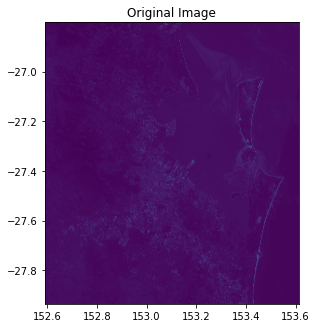

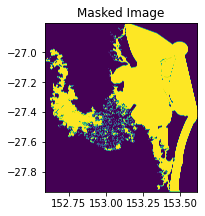

<AxesSubplot:title={'center':'Masked Image'}>

In [56]:
plt.figure(figsize=(10, 15))
plt.subplot(1, 2, 1)
plt.title("Original Image")
show(src)  
plt.subplot(1, 2, 2)
plt.title("Masked Image")  
show(rasterio.open(labels_file))  